In [2]:
!pip install -U neuralforecast==1.6.4
!pip install torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.6/170.6 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.1/68.1 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 125.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pandas as pd

# Replace with your actual found path
file_path = '/content/drive/MyDrive/Colab Notebooks/final_merged_dataset_hourly.parquet'

# Load the Parquet file
merged_data = pd.read_parquet(file_path)

print(merged_data.head())

             datetime      Open      High       Low     Close    Volume  \
0 2021-01-01 00:00:00  0.250730  0.251106  0.250628  0.250493  0.076344   
1 2021-01-01 01:00:00  0.251433  0.251695  0.251353  0.251520  0.015258   
2 2021-01-01 02:00:00  0.256154  0.256011  0.255263  0.255877  0.034476   
3 2021-01-01 03:00:00  0.252147  0.252928  0.252351  0.253123  0.010795   
4 2021-01-01 04:00:00  0.254932  0.255284  0.254180  0.254066  0.023016   

   sentiment_score  bert_sentiment  prev_close  prev_vader_sentiment  \
0              0.0             0.0    0.250493                   0.0   
1              0.0             0.0    0.250493                   0.0   
2              0.0             0.0    0.251520                   0.0   
3              0.0             0.0    0.255877                   0.0   
4              0.0             0.0    0.253123                   0.0   

   prev_bert_sentiment  volatility_7d  volatility_14d  volatility_30d  \
0                  0.0       0.050683      

In [6]:
from neuralforecast.models import PatchTST
from neuralforecast import NeuralForecast

In [7]:
# Convert for PatchTST target df
df = merged_data[['datetime', 'Close']].copy()
df.rename(columns={'datetime': 'ds', 'Close': 'y'}, inplace=True)
df['unique_id'] = 'BTC'  # Single series
df = df[['unique_id', 'ds', 'y']]

In [23]:
# Convert for PatchTST target df
df = merged_data[['datetime', 'Close']].copy()
df.rename(columns={'datetime': 'ds', 'Close': 'y'}, inplace=True)
df['unique_id'] = 'BTC'  # Single series
df = df[['unique_id', 'ds', 'y']]

In [24]:
val_size = 168

# Train on everything before the last 168 rows
df_train = df[:-val_size].copy()
df_val_truth = df[-val_size:].copy()

In [11]:
from neuralforecast import NeuralForecast
from neuralforecast.models import PatchTST
from neuralforecast.losses.pytorch import MSE

patchtst = PatchTST(
    h=24,
    input_size=168,
    patch_len=16,
    stride=8,
    encoder_layers=3,           # 🔁 Replaces n_blocks
    n_heads=4,
    hidden_size=128,            # 🔁 Replaces d_model
    linear_hidden_size=256,     # Optional, helps model capacity
    dropout=0.1,
    fc_dropout=0.1,
    head_dropout=0.0,
    learning_rate=1e-3,
    scaler_type='robust',
    loss=MSE(),
    random_seed=42
)

nf = NeuralForecast(models=[patchtst], freq='H')
nf.fit(df=df_train)

INFO:lightning_fabric.utilities.seed:Seed set to 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [12]:
forecasts_df = nf.predict()
forecasts_df = forecasts_df.reset_index()

Predicting: |          | 0/? [00:00<?, ?it/s]

In [13]:
df_val_truth['ds'] = pd.to_datetime(df_val_truth['ds'])
forecasts_df['ds'] = pd.to_datetime(forecasts_df['ds'])

df_eval = pd.merge(df_val_truth, forecasts_df.rename(columns={'PatchTST': 'y_hat'}), on=['unique_id', 'ds'], how='inner')

from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(df_eval['y'], df_eval['y_hat']))

def safe_mape(y_true, y_pred, eps=1e-8):
    return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

mape = safe_mape(df_eval['y'], df_eval['y_hat'])

print(f"✅ RMSE: {rmse:.4f}")
print(f"✅ Safe MAPE: {mape:.2f}%")

✅ RMSE: 0.0074
✅ Safe MAPE: 5.00%


In [81]:
rmse

np.float64(0.007405744020328252)

In [ ]:
!pip install mlflow

In [79]:
import os
import mlflow
import mlflow.sklearn

# Set up MLflow tracking URI and authentication for DagsHub
MLFLOW_TRACKING_URI = "https://dagshub.com/vamsisaigarapati/bitcoin_price_pred_CSE574.mlflow"
os.environ['MLFLOW_TRACKING_USERNAME'] = 'vamsisaigarapati'
os.environ['MLFLOW_TRACKING_PASSWORD'] = '0d66986d30f48a915d60b73c435bdae6ee103eb8'

# Configure MLflow
mlflow.set_tracking_uri(uri=MLFLOW_TRACKING_URI)
mlflow.set_experiment("Bitcoin_Price_Prediction_CSE574")

def log_experiment(model_name, params, metrics, model_object=None):
    """
    Logs model, parameters, and evaluation metrics to MLflow (DagsHub).
    Model logging is optional.

    :param model_name: (str) Name of the model (e.g., "ARIMA", "XGBoost", "LSTM").
    :param params: (dict) Hyperparameters used for the model.
    :param metrics: (dict) Performance metrics (e.g., RMSE, MAPE).
    :param model_object: (optional) Trained model object to be saved (e.g., sklearn, SARIMA, etc.)
    """
    with mlflow.start_run() as run:
        run_id = run.info.run_id

        # 1. Save the model only if provided
        if model_object is not None:
            mlflow.sklearn.log_model(
                sk_model=model_object,
                artifact_path="model",
                registered_model_name=f"{model_name}_Model"
            )

        # 2. Log parameters
        for param_name, param_value in params.items():
            mlflow.log_param(param_name, param_value)

        # 3. Log metrics
        for metric_name, metric_value in metrics.items():
            mlflow.log_metric(metric_name, metric_value)

        # 4. Set a tag for better tracking
        mlflow.set_tag("mlflow.runName", f"{model_name}")

        print(f"✅ {model_name} logged successfully to DagsHub MLflow.")


In [83]:
# Define parameters
params = {
    "architecture": "PatchTST",
    "input_features": "price + sentiment",
    "sequence_length": 24,        # or whatever `context_length` you used
    "prediction_length": 24,      # if predicting next 24 hours
    "patch_length": 6,            # typical for PatchTST
    "stride": 1,
    "d_model": 512,
    "n_heads": 8,
    "dropout_rate": 0.1,
    "optimizer": "Adam",
    "loss": "MSE",
    "epochs": 20,
    "batch_size": 32              # adjust based on your runtime setup
}

# Define metrics
metrics = {
    "RMSE": rmse,        # replace with actual RMSE value
    "MAPE": mape    # replace with actual Safe_MAPE value
}

# Log the model
log_experiment(
    model_name="PatchTST_advanced",
    model_object=nf,  # or `nf` if using NeuralForecast
    params=params,
    metrics=metrics
)

2025/04/25 01:54:30 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.21.0+cu124) contains a local version label (+cu124). MLflow logged a pip requirement for this package as 'torchvision==0.21.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/04/25 01:54:30 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
Registered model 'PatchTST_advanced_Model' already exists. Creating a new version of this model...
2025/04/25 01:54:33 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: PatchTST_advanced_Model, version 2
Created version '2' of model 'PatchTST_advanced_Model'.


✅ PatchTST_advanced logged successfully to DagsHub MLflow.
🏃 View run PatchTST_advanced at: https://dagshub.com/vamsisaigarapati/bitcoin_price_pred_CSE574.mlflow/#/experiments/0/runs/e61a8e76b5624166a57fddf49f40ec20
🧪 View experiment at: https://dagshub.com/vamsisaigarapati/bitcoin_price_pred_CSE574.mlflow/#/experiments/0


## OOD Testing

In [31]:
# 1. Extract original target values
y_clean = df_val_truth['y'].values

# 2. Define noise level (2% of Close price range)
noise_pct = 0.02
price_range = y_clean.max() - y_clean.min()
noise_std = noise_pct * price_range

# 3. Add noise to Close prices
np.random.seed(42)
y_noisy = y_clean + np.random.normal(0, noise_std, size=y_clean.shape)

# 4. Clip to stay within min/max range (optional)
y_noisy = np.clip(y_noisy, y_clean.min(), y_clean.max())

# 5. Create noisy test DataFrame
df_val_noisy = df_val_truth.copy()
df_val_noisy['y'] = y_noisy

In [32]:
df_val_noisy['y']

18097    0.139829
18098    0.139533
18099    0.137062
18100    0.135623
18101    0.131778
           ...   
18260    0.141060
18261    0.142183
18262    0.141632
18263    0.142275
18264    0.143532
Name: y, Length: 168, dtype: float64

In [33]:
# Forecast using same model on the noisy dataset
nf = NeuralForecast(models=[patchtst], freq='H')
nf.fit(df=df_train)

forecasts_df_noisy = nf.predict().reset_index()
forecasts_df_noisy.rename(columns={'PatchTST': 'y_hat_noisy'}, inplace=True)

# Align noisy prediction with noisy ground truth
df_val_noisy['ds'] = pd.to_datetime(df_val_noisy['ds'])
forecasts_df_noisy['ds'] = pd.to_datetime(forecasts_df_noisy['ds'])

df_eval_noisy = pd.merge(df_val_noisy, forecasts_df_noisy, on=['unique_id', 'ds'], how='inner')

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [34]:
from sklearn.metrics import mean_absolute_percentage_error

# Original clean prediction already done
y_true_clean = df_eval['y'].values
y_pred_clean = df_eval['y_hat'].values

# Noisy prediction
y_true_noisy = df_eval_noisy['y'].values
y_pred_noisy = df_eval_noisy['y_hat_noisy'].values

# Mask for Safe MAPE
mask = np.abs(y_true_clean) > 0.01

# Clean
rmse_clean = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
mape_clean = mean_absolute_percentage_error(y_true_clean[mask], y_pred_clean[mask]) * 100

# Noisy
rmse_noisy = np.sqrt(mean_squared_error(y_true_noisy, y_pred_noisy))
mape_noisy = mean_absolute_percentage_error(y_true_noisy[mask], y_pred_noisy[mask]) * 100

def pct_increase(a, b):
    return (b - a) / a * 100

print("🔎 PatchTST — OOD Noise Robustness\n"
      "--------------------------------")
print(f"Clean  RMSE : {rmse_clean:.6f}")
print(f"Noisy  RMSE : {rmse_noisy:.6f}  "
      f"({pct_increase(rmse_clean, rmse_noisy):+.1f} %)\n")

print(f"Clean  Safe MAPE : {mape_clean:.2f}%")
print(f"Noisy  Safe MAPE : {mape_noisy:.2f}%  "
      f"({pct_increase(mape_clean, mape_noisy):+.1f} %)")

🔎 PatchTST — OOD Noise Robustness
--------------------------------
Clean  RMSE : 0.007406
Noisy  RMSE : 0.007470  (+0.9 %)

Clean  Safe MAPE : 5.00%
Noisy  Safe MAPE : 5.05%  (+1.1 %)


## Heteroscedasticity Check for PatchTST

In [62]:
# Re-fit model on full data excluding the last 336 hours
df_train = df.copy()
df_eval_truth = df[-336:].copy()

nf = NeuralForecast(models=[patchtst], freq='H')
nf.fit(df=df_train)

# Rolling forecast for all available insample windows
forecasts_df = nf.predict_insample().reset_index()
forecasts_df.rename(columns={'PatchTST': 'y_hat'}, inplace=True)

# Align with truth
forecasts_df['ds'] = pd.to_datetime(forecasts_df['ds'])
df_eval_truth['ds'] = pd.to_datetime(df_eval_truth['ds'])



Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [63]:
df_eval = pd.merge(df_eval_truth, forecasts_df, on=['unique_id', 'ds'], how='inner')

In [64]:
df_eval

unique_id                  ds       y_x   index              cutoff  \
0          BTC 2023-01-18 01:00:00  0.107916  429767 2023-01-17 01:00:00   
1          BTC 2023-01-18 01:00:00  0.107916  429790 2023-01-17 02:00:00   
2          BTC 2023-01-18 01:00:00  0.107916  429813 2023-01-17 03:00:00   
3          BTC 2023-01-18 01:00:00  0.107916  429836 2023-01-17 04:00:00   
4          BTC 2023-01-18 01:00:00  0.107916  429859 2023-01-17 05:00:00   
...        ...                 ...       ...     ...                 ...   
7783       BTC 2023-01-31 22:00:00  0.141403  437782 2023-01-30 23:00:00   
7784       BTC 2023-01-31 22:00:00  0.141403  437805 2023-01-31 00:00:00   
7785       BTC 2023-01-31 23:00:00  0.141818  437783 2023-01-30 23:00:00   
7786       BTC 2023-01-31 23:00:00  0.141818  437806 2023-01-31 00:00:00   
7787       BTC 2023-02-01 00:00:00  0.142479  437807 2023-01-31 00:00:00   

         y_hat       y_y  
0     0.106991  0.107916  
1     0.106639  0.107916  
2     0.104445  0.107916  
3     0.103850  0.107916  
4     0.106250  0.107916  
...        ...       ...  
7783  0.142363  0.141403  
7784  0.142382  0.141403  
7785  0.142535  0.141818  
7786  0.142525  0.141818  
7787  0.142301  0.142479  

[7788 rows x 7 columns]

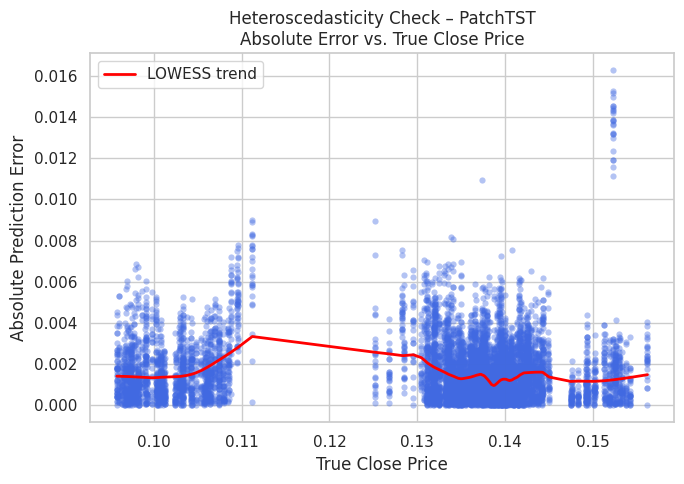

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from statsmodels.nonparametric.smoothers_lowess import lowess

# Step 1: Calculate errors from df_eval
errors = df_eval['y_y'] - df_eval['y_hat']
abs_errors = np.abs(errors)

# Step 2: Create DataFrame for plotting
df_plot = pd.DataFrame({
    "TrueClose": df_eval['y_y'],
    "AbsError" : abs_errors
})

# Step 3: LOWESS smoothing
lowess_curve = lowess(
    df_plot["AbsError"],
    df_plot["TrueClose"],
    frac=0.15,          # Controls smoothness; adjust if needed
    return_sorted=True
)

# Step 4: Plot
plt.figure(figsize=(7, 5))
sns.set(style="whitegrid")

# 💠 Scatterplot of true price vs error
sns.scatterplot(
    data=df_plot,
    x="TrueClose",
    y="AbsError",
    alpha=0.4,            # transparency
    s=20,                 # marker size
    color='royalblue',    # blue points
    linewidth=0
)

plt.plot(lowess_curve[:, 0], lowess_curve[:, 1],
         color="red", linewidth=2, label="LOWESS trend")

# Titles and labels
plt.title("Heteroscedasticity Check – PatchTST\nAbsolute Error vs. True Close Price")
plt.xlabel("True Close Price")
plt.ylabel("Absolute Prediction Error")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [44]:
df_plot

TrueClose  AbsError
0    0.107916  0.002293
1    0.108539  0.002474
2    0.107463  0.004121
3    0.105896  0.004921
4    0.104292  0.007211
5    0.105840  0.005958
6    0.106047  0.006887
7    0.106916  0.004450
8    0.106557  0.006886
9    0.106859  0.005259
10   0.107369  0.003333
11   0.106368  0.005660
12   0.107369  0.005765
13   0.106142  0.007586
14   0.105708  0.009467
15   0.104764  0.012518
16   0.105425  0.013893
17   0.106406  0.016589
18   0.109521  0.013698
19   0.109540  0.012196
20   0.100215  0.022628
21   0.099101  0.025559
22   0.098667  0.027697
23   0.099781  0.029531

## Double descent curves

In [67]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Define training fractions to simulate
fractions = [0.05, 0.10, 0.20, 0.40, 0.60, 0.80, 1.00]
rmse_curve, mape_curve = [], []

In [76]:
for frac in fractions:
    n = int(frac * len(df[:-168]))  # Leave last 168 as fixed validation
    df_frac_train = df[:n].copy()
    df_val_truth = df[-168:].copy()

    # Re-initialize and retrain PatchTST
    patchtst = PatchTST(
        h=24,
        input_size=168,
        patch_len=16,
        stride=8,
        encoder_layers=3,
        n_heads=4,
        hidden_size=128,
        linear_hidden_size=256,
        dropout=0.1,
        fc_dropout=0.1,
        head_dropout=0.0,
        learning_rate=1e-3,
        scaler_type='robust',
        loss=MSE(),
        random_seed=42
    )

    nf = NeuralForecast(models=[patchtst], freq='H')
    nf.fit(df=df_frac_train)
    forecasts_df = nf.predict().reset_index()
    forecasts_df.rename(columns={'PatchTST': 'y_hat'}, inplace=True)

    # Evaluate
    df_val_truth['ds'] = pd.to_datetime(df_val_truth['ds'])
    forecasts_df['ds'] = pd.to_datetime(forecasts_df['ds'])

    df_eval = pd.merge(df, forecasts_df, on=['unique_id', 'ds'], how='inner')

    y_true = df_eval['y'].values
    y_pred = df_eval['y_hat'].values
    mask = np.abs(y_true) > 0.01

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true[mask], y_pred[mask]) * 100

    rmse_curve.append(rmse)
    mape_curve.append(mape)

    print(f"{int(frac*100):>3}%  | RMSE = {rmse:.5f} | Safe MAPE = {mape:6.2f}%")

INFO:lightning_fabric.utilities.seed:Seed set to 42


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42


  5%  | RMSE = 0.01064 | Safe MAPE =   2.02%


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42


 10%  | RMSE = 0.02752 | Safe MAPE =   3.03%


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42


 20%  | RMSE = 0.01187 | Safe MAPE =   2.58%


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42


 40%  | RMSE = 0.01258 | Safe MAPE =   1.14%


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42


 60%  | RMSE = 0.00751 | Safe MAPE =   1.09%


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:lightning_fabric.utilities.seed:Seed set to 42


 80%  | RMSE = 0.00458 | Safe MAPE =   4.63%


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

100%  | RMSE = 0.00741 | Safe MAPE =   5.00%


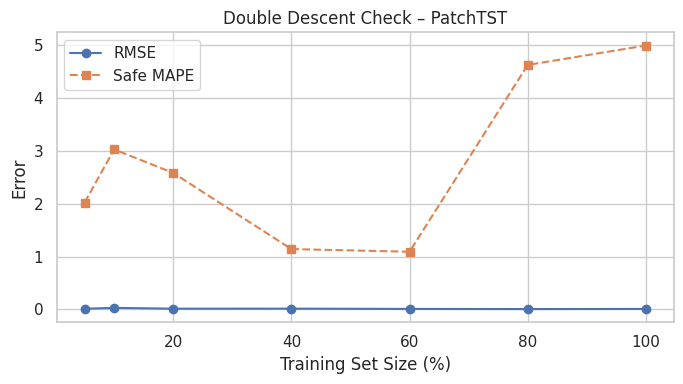

In [77]:
plt.figure(figsize=(7, 4))
plt.plot(np.array(fractions) * 100, rmse_curve, 'o-', label='RMSE')
plt.plot(np.array(fractions) * 100, mape_curve, 's--', label='Safe MAPE')

plt.xlabel("Training Set Size (%)")
plt.ylabel("Error")
plt.title("Double Descent Check – PatchTST")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()